In [2]:
import IPython.display as ipd
import random
from segment_saliency_dataset import SegmentSaliencyDataset
from postprocess_saliency import visualize_saliency_map
dataset = SegmentSaliencyDataset(src_dir="/checkpoint/ortal1/Dsets/data_from_alon/chroma_maps")
# dataset = SegmentSaliencyDataset(src_dir="../mtg_jamendo_raw_30s_audio_00_saliencies")
print(f'num tracks in dataset: {len(dataset)}')

# track_idx = '24'
# track_idx = '000157874'

# # by trackname + offset
saliency_dict = dataset.get_saliency(track_idx, offset=0)
# print(saliency_dict.keys())
# print(saliency_dict['salience'].shape)

# # by trackname + offset - argmax
# saliency_dict = dataset.get_saliency(track_idx, offset=0, argmax=True)
# print(saliency_dict.keys())
# print(f"with argmax the shape is: {saliency_dict['salience'].shape}")
# print(f"and it looks like this: {saliency_dict['salience'][:30]}")

# random sample
# wav, saliency_dict, wav_sr = dataset.__getitem__(0, offset=90.0)
saliency_dict = self.chroma_dset.get_saliency(fname, offset=chunk_offset / 32000)
chroma = saliency_dict['salience'].T
chroma = torch.Tensor(chroma).float()
wav, saliency_dict, wav_sr = dataset[random.randint(0, len(dataset)-1)]

ipd.display(ipd.Audio(wav, rate=wav_sr))

visualize_saliency_map(saliency_dict['salience'].T, saliency_dict['freqs'], saliency_dict['times'], matplotlib=True)


KeyboardInterrupt: 

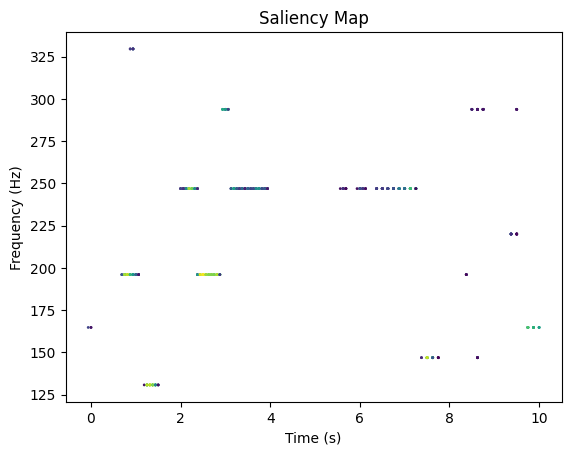

In [9]:
import IPython.display as ipd
import random
from segment_saliency_dataset import SegmentSaliencyDataset
from postprocess_saliency import visualize_saliency_map


wav, saliency_dict, wav_sr = dataset[random.randint(0, len(dataset)-1)]

ipd.display(ipd.Audio(wav, rate=wav_sr))

visualize_saliency_map(saliency_dict['salience'].T, saliency_dict['freqs'], saliency_dict['times'], matplotlib=True)

In [9]:
# merge all jsonl to single file
from tqdm import tqdm
# files = ['mmi_test.jsonl']
# files = ['mmi_train.jsonl', 'mmi_val.jsonl', 'mmi_test.jsonl']

# roots = [
#     "/checkpoint/ortal1/Dsets/data_from_alon/mmi", 
#     "/checkpoint/ortal1/Dsets/data_from_alon/mmi-nv", 
#     "/checkpoint/ortal1/Dsets/data_from_alon/musiccaps", 
#     "/checkpoint/ortal1/Dsets/data_from_alon/minitest_mmi", 
# ]

def get_single_path_from_line(line):
    line = line.split('"path": "')[-1]
    line = line.split('",')[0]
    return line

fpaths = set()
for root, file in tqdm([
    ("/checkpoint/ortal1/Dsets/data_from_alon/mmi", 'mmi_train.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/mmi", 'mmi_val.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/mmi", 'mmi_test.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/mmi-nv", 'mmi_train.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/musiccaps", 'mmi_test.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/minitest_mmi", 'mmi_train.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/minitest_mmi", 'mmi_val.jsonl'),
    ("/checkpoint/ortal1/Dsets/data_from_alon/minitest_mmi", 'mmi_test.jsonl'),
]):
    with open(f"{root}/{file}", "r") as fp:
        lines = fp.readlines()
    for line in lines:
        fpath = get_single_path_from_line(line)
        fpaths.add(fpath)

with open(f"/checkpoint/ortal1/Dsets/data_from_alon/all_files_for_chroma_script.txt", "w") as fp:
    fp.write("\n".join(fpaths))

100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


In [2]:
import os

rt = "/checkpoint/ortal1/Dsets/data_from_alon/chroma_maps/predict_saliency_{}.err"

unfinished = list()
failed = list()
missing = list()
for i in range(1000):
    fpath = rt.format(i)
    if os.path.exists(fpath):
        with open(fpath, "r") as fp:
            lines = "".join(fp.readlines())
        if "error" in lines.lower():
            failed.append(i)
        elif "100%" not in lines:
            unfinished.append(i)
    else:
        missing.append(i)

print(f"unfinished: {len(unfinished)}")
# print(unfinished)
print(f"failed: {len(failed)}")
# print(failed)
print("missing:")
print(missing)

unfinished: 0
failed: 778
missing:
[]


In [2]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

missing_files = list()
bad_files = list()
rt = "/checkpoint/ortal1/Dsets/data_from_alon/chroma_maps"

def parse_single(fpath):
    missing, bad = None, None
    if not os.path.exists(fpath):
        missing = line
    else:
        try:
            np.load(fpath)
        except:
            bad = fpath
    return missing, bad

for file in os.listdir(rt):
    if ".txt" in file:
        with open(f"{rt}/{file}", "r") as fp:
            lines = fp.readlines()
        for line in lines:
            fname = line.split("/")[-1].split(".")[0]
            if fname == "079889626":
                bad_files.append(line)

        # with ThreadPoolExecutor() as pool:
        #     pending = list()
        #     for line in lines:
        #         fname = line.split("/")[-1].split(".")[0]
        #         pending.append(pool.submit(parse_single, f"{rt}/{fname}_multif0_salience.npz"))
        #     for p in tqdm(pending):
        #         ms, bd = p.result()
        #         if ms is not None:
        #             missing_files.append(ms)
        #         if bd is not None:
        #             bad_files.append(bd)


print(f"missing: {len(missing_files)}")
if len(missing_files) > 0:
    with open("/checkpoint/ortal1/Projects/forked_deepsalience_repo/missing_files.txt", "w") as fp:
        fp.write("".join(missing_files))

print(f"bad_files: {len(bad_files)}")
if len(bad_files) > 0:
    with open("/checkpoint/ortal1/Projects/forked_deepsalience_repo/bad_files.txt", "w") as fp:
        fp.write("".join(bad_files))
    print(bad_files)

missing: 0
bad_files: 2
['/datasets01/shutterstock-music-resampled/p5_32khz_wav/89/5fe/ea3/953f/4852/079889626.wav\n', '/datasets01/shutterstock-music-resampled-nv/p5_32khz_wav/89/5fe/ea3/953f/4852/079889626.wav\n']


In [4]:
n_shards = 100

with open("/checkpoint/ortal1/Projects/forked_deepsalience_repo/missing_files.txt", "r") as fp:
    lines = fp.readlines()

shard_size = len(lines) // n_shards

for i in range(n_shards - 1):
    r = len(lines) if i == len(lines) - 1 else (i + 1) * shard_size
    with open(f"/checkpoint/ortal1/Projects/forked_deepsalience_repo/shards_missing_files/{i}.txt", "w") as fpp:
        fpp.write("".join(lines[i*shard_size: r]))
    print(f"{i}: {len(lines[i*shard_size: r])}")
with open(f"/checkpoint/ortal1/Projects/forked_deepsalience_repo/shards_missing_files/{i+1}.txt", "w") as fpp:
    fpp.write("".join(lines[(i + 1)*shard_size:]))
    print(f"{i + 1}: {len(lines[(i + 1)*shard_size:])}")

0: 169
1: 169
2: 169
3: 169
4: 169
5: 169
6: 169
7: 169
8: 169
9: 169
10: 169
11: 169
12: 169
13: 169
14: 169
15: 169
16: 169
17: 169
18: 169
19: 169
20: 169
21: 169
22: 169
23: 169
24: 169
25: 169
26: 169
27: 169
28: 169
29: 169
30: 169
31: 169
32: 169
33: 169


34: 169
35: 169
36: 169
37: 169
38: 169
39: 169
40: 169
41: 169
42: 169
43: 169
44: 169
45: 169
46: 169
47: 169
48: 169
49: 169
50: 169
51: 169
52: 169
53: 169
54: 169
55: 169
56: 169
57: 169
58: 169
59: 169
60: 169
61: 169
62: 169
63: 169
64: 169
65: 169
66: 169
67: 169
68: 169
69: 169
70: 169
71: 169
72: 169
73: 169
74: 169
75: 169
76: 169
77: 169
78: 169
79: 169
80: 169
81: 169
82: 169
83: 169
84: 169
85: 169
86: 169
87: 169
88: 169
89: 169
90: 169
91: 169
92: 169
93: 169
94: 169
95: 169
96: 169
97: 169
98: 169
99: 240


In [4]:
import torch
import omegaconf
import pickle

key = "ItstzW7xuDU"

rt = "/checkpoint/ortal1/Dsets/data_from_alon/chords/combined/test_combined_chord_dict.pkl"

d = pickle.load(open(rt, "rb"))
d2 = pickle.load(open("/checkpoint/ortal1/Dsets/data_from_alon/musiccaps/chords/combined/test_combined_chord_dict.pkl", "rb"))
print("")